Free Ollama GraphRag with Llama 3.2 currently

Inspired by: https://github.com/NirDiamant/RAG_Techniques/blob/main/all_rag_techniques_runnable_scripts/graph_rag.py

# Step-by-Step Breakdown of the Process

    Document Loading and Processing:
        Loading Documents: The PyPDFLoader loads the specified PDF document. In this case, it is Understanding Climate Change.pdf.
        Splitting and Embedding: The DocumentProcessor class splits the document into smaller chunks (e.g., 1000 characters) using RecursiveCharacterTextSplitter. Each chunk is then embedded using the OllamaEmbeddings model (llama3.2).
        Vector Store Creation: The processed chunks are stored in a Chroma vector store, which enables fast similarity-based document retrieval.

    Knowledge Graph Construction:
        Building the Graph: The KnowledgeGraph class constructs a graph using the document chunks as nodes. Each node is represented by its content and connected to other nodes based on similarity and shared concepts.
        Concept Extraction: Concepts are extracted from each document chunk using a combination of the spaCy NLP model and the ChatOllama language model.
        Edge Creation: Edges are added between nodes based on the cosine similarity of their embeddings and shared concepts. The edge weight is calculated using a custom formula that combines similarity and concept overlap.

    Query Handling and Graph Traversal:
        Retrieving Relevant Documents: When a query is issued, the system first retrieves the most relevant documents from the vector store using similarity-based search.
        Expanding Context with Graph Traversal: The system then traverses the knowledge graph starting from the most relevant nodes, expanding the context by visiting related nodes based on edge weights and priority. This traversal is managed using a priority queue (heap) that ensures the most promising nodes are explored first.
        Answer Generation: As the graph is traversed, the accumulated context is checked to see if it provides a complete answer. If not, the traversal continues until an answer is found or the context is expanded enough to generate a final answer using the language model.

    Visualization:
        The graph traversal is visualized using networkx and matplotlib. Nodes are colored to represent different stages of the traversal (e.g., start node, end node, regular nodes), and edges are displayed based on their weights.
        The graph in the image shows the path taken through the nodes, highlighting the connections and shared concepts.

Output Analysis

    The system's output indicates that the main cause of climate change, based on the provided context, is primarily driven by human activities, particularly the emission of greenhouse gases. This conclusion is reached by traversing nodes that cover topics like greenhouse gases, deforestation, and carbon storage.

    The graph visualization shows the traversal path through the nodes. The starting node (green) and the ending node (red) highlight the trajectory taken through the graph. The concepts and content of each node are displayed, giving a clear picture of how the traversal occurred.

# Potentials

* 

In [19]:
%%writefile ../../../src/graphrag/networkx/examples/document_processor.py

import nltk
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings  # Updated import
from langchain_community.vectorstores import Chroma  # Updated import

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

class DocumentProcessor:
    def __init__(self):
        """
        Initializes the DocumentProcessor with a text splitter and embeddings.
        """
        self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
        self.embeddings = OllamaEmbeddings(model="llama3.2")

    def process_documents(self, documents):
        splits = self.text_splitter.split_documents(documents)
        vector_store = Chroma.from_documents(
            splits,
            self.embeddings,
            persist_directory="../../../data/graph_chroma_dbs"
        )
        return splits, vector_store


Overwriting ../../../src/graphrag/networkx/examples/document_processor.py


In [20]:
%%writefile ../../../src/graphrag/networkx/examples/knowledge_graph.py

import nltk
import spacy
import networkx as nx
from pydantic import BaseModel, Field
from typing import List, Dict
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from langchain_core.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain.schema import AIMessage

# Download necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

class KnowledgeGraph:
    def __init__(self):
        """
        Initializes the KnowledgeGraph with a graph, lemmatizer, and NLP model.
        """
        self.graph = nx.Graph()
        self.lemmatizer = nltk.WordNetLemmatizer()
        self.concept_cache = {}
        self.nlp = self._load_spacy_model()
        self.edges_threshold = 0.8

    def build_graph(self, splits, llm, embedding_model):
        self._add_nodes(splits)
        embeddings = self._create_embeddings(splits, embedding_model)
        self._extract_concepts(splits, llm)
        self._add_edges(embeddings)

    def _add_nodes(self, splits):
        """
        Adds nodes to the graph from the document splits.
        """
        for i, split in enumerate(splits):
            self.graph.add_node(i, content=split.page_content)

    def _create_embeddings(self, splits, embedding_model):
        """
        Creates embeddings for the document splits using the embedding model.
        """
        texts = [split.page_content for split in splits]
        return embedding_model.embed_documents(texts)

    def _compute_similarities(self, embeddings):
        """
        Computes the cosine similarity matrix for the embeddings.
        """
        from sklearn.metrics.pairwise import cosine_similarity
        return cosine_similarity(embeddings)

    def _load_spacy_model(self):
        """
        Loads the spaCy NLP model, downloading it if necessary.
        """
        try:
            return spacy.load("en_core_web_sm")
        except OSError:
            print("Downloading spaCy model...")
            spacy.cli.download("en_core_web_sm")
            return spacy.load("en_core_web_sm")

    def _extract_concepts_and_entities(self, content, llm):
        """
        Extracts concepts and named entities from the content using spaCy and a large language model.
        """
        if content in self.concept_cache:
            return self.concept_cache[content]

        # Extract named entities using spaCy
        doc = self.nlp(content)
        named_entities = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "ORG", "GPE", "WORK_OF_ART"]]

        # Extract general concepts using LLM
        concept_extraction_prompt = PromptTemplate(
            input_variables=["text"],
            template="Extract key concepts (excluding named entities) from the following text:\n\n{text}\n\nKey concepts:"
        )
        concept_chain = concept_extraction_prompt | llm
        response = concept_chain.invoke({"text": content})

        # Check if response is an AIMessage object and get content
        if isinstance(response, AIMessage):
            general_concepts = response.content
        else:
            general_concepts = response

        # Split the response into individual concepts
        general_concepts = [concept.strip() for concept in general_concepts.split(',')]

        # Combine named entities and general concepts
        all_concepts = list(set(named_entities + general_concepts))

        self.concept_cache[content] = all_concepts
        return all_concepts

    def _extract_concepts(self, splits, llm):
        """
        Extracts concepts for all document splits using multi-threading.
        """
        with ThreadPoolExecutor() as executor:
            future_to_node = {executor.submit(self._extract_concepts_and_entities, split.page_content, llm): i
                              for i, split in enumerate(splits)}

            for future in tqdm(as_completed(future_to_node), total=len(splits),
                               desc="Extracting concepts and entities"):
                node = future_to_node[future]
                concepts = future.result()
                self.graph.nodes[node]['concepts'] = concepts

    def _add_edges(self, embeddings):
        """
        Adds edges to the graph based on the similarity of embeddings and shared concepts.
        """
        similarity_matrix = self._compute_similarities(embeddings)
        num_nodes = len(self.graph.nodes)

        for node1 in tqdm(range(num_nodes), desc="Adding edges"):
            for node2 in range(node1 + 1, num_nodes):
                similarity_score = similarity_matrix[node1][node2]
                if similarity_score > self.edges_threshold:
                    shared_concepts = set(self.graph.nodes[node1]['concepts']) & set(
                        self.graph.nodes[node2]['concepts'])
                    edge_weight = self._calculate_edge_weight(node1, node2, similarity_score, shared_concepts)
                    self.graph.add_edge(node1, node2, weight=edge_weight,
                                        similarity=similarity_score,
                                        shared_concepts=list(shared_concepts))

    def _calculate_edge_weight(self, node1, node2, similarity_score, shared_concepts, alpha=0.7, beta=0.3):
        """
        Calculates the weight of an edge based on similarity score and shared concepts.
        """
        max_possible_shared = min(len(self.graph.nodes[node1]['concepts']), len(self.graph.nodes[node2]['concepts']))
        normalized_shared_concepts = len(shared_concepts) / max_possible_shared if max_possible_shared > 0 else 0
        return alpha * similarity_score + beta * normalized_shared_concepts

    def _lemmatize_concept(self, concept):
        """
        Lemmatizes a given concept.
        """
        return ' '.join([self.lemmatizer.lemmatize(word) for word in concept.lower().split()])


Overwriting ../../../src/graphrag/networkx/examples/knowledge_graph.py


In [21]:
%%writefile ../../../src/graphrag/networkx/examples/query_engine.py

import heapq
from typing import Tuple, List, Dict
from langchain_core.prompts import PromptTemplate
from langchain_ollama import ChatOllama
from langchain.schema import AIMessage

class QueryEngine:
    def __init__(self, vector_store, knowledge_graph):
        self.vector_store = vector_store
        self.knowledge_graph = knowledge_graph
        self.llm = ChatOllama(model="llama3.2", temperature=0)
        self.max_context_length = 4000
        self.answer_check_chain = self._create_answer_check_chain()

    def _create_answer_check_chain(self):
        """
        Creates a chain to check if the context provides a complete answer to the query.
        """
        answer_check_prompt = PromptTemplate(
            input_variables=["query", "context"],
            template="Given the query: '{query}'\n\nAnd the current context:\n{context}\n\nDoes this context provide a complete answer to the query? If yes, provide the answer. If no, state that the answer is incomplete."
        )
        return answer_check_prompt | self.llm

    def _check_answer(self, query: str, context: str) -> Tuple[bool, str]:
        """
        Checks if the current context provides a complete answer to the query.
        """
        response = self.answer_check_chain.invoke({"query": query, "context": context})
        is_complete = "Yes" in response
        answer = response.split("Answer:")[-1].strip() if is_complete else ""
        return is_complete, answer

    def _expand_context(self, query: str, relevant_docs) -> Tuple[str, List[int], Dict[int, str], str]:
        """
        Expands the context by traversing the knowledge graph using a Dijkstra-like approach.
        """
        expanded_context = ""
        traversal_path = []
        visited_concepts = set()
        filtered_content = {}
        final_answer = ""

        priority_queue = []
        distances = {}

        # Initialize priority queue with closest nodes from relevant docs
        for doc in relevant_docs:
            # Find the most similar node in the knowledge graph for each relevant document
            closest_nodes = self.vector_store.similarity_search_with_score(doc.page_content, k=1)
            closest_node_content, similarity_score = closest_nodes[0]

            # Get the corresponding node in our knowledge graph
            closest_node = next(n for n in self.knowledge_graph.graph.nodes if
                                self.knowledge_graph.graph.nodes[n]['content'] == closest_node_content.page_content)

            # Initialize priority (inverse of similarity score for min-heap behavior)
            priority = 1 / similarity_score
            heapq.heappush(priority_queue, (priority, closest_node))
            distances[closest_node] = priority

        while priority_queue:
            # Get the node with the highest priority (lowest distance value)
            current_priority, current_node = heapq.heappop(priority_queue)

            # Skip if we've already found a better path to this node
            if current_priority > distances.get(current_node, float('inf')):
                continue

            if current_node not in traversal_path:
                traversal_path.append(current_node)
                node_content = self.knowledge_graph.graph.nodes[current_node]['content']
                node_concepts = self.knowledge_graph.graph.nodes[current_node]['concepts']

                # Add node content to our accumulated context
                filtered_content[current_node] = node_content
                expanded_context += "\n" + node_content if expanded_context else node_content

                # Check if we have a complete answer with the current context
                is_complete, answer = self._check_answer(query, expanded_context)
                if is_complete:
                    final_answer = answer
                    break

                # Process the concepts of the current node
                node_concepts_set = set(self.knowledge_graph._lemmatize_concept(c) for c in node_concepts)
                if not node_concepts_set.issubset(visited_concepts):
                    visited_concepts.update(node_concepts_set)

                    # Explore neighbors
                    for neighbor in self.knowledge_graph.graph.neighbors(current_node):
                        edge_data = self.knowledge_graph.graph[current_node][neighbor]
                        edge_weight = edge_data['weight']

                        # Calculate new distance (priority) to the neighbor
                        distance = current_priority + (1 / edge_weight)

                        # If we've found a stronger connection to the neighbor, update its distance
                        if distance < distances.get(neighbor, float('inf')):
                            distances[neighbor] = distance
                            heapq.heappush(priority_queue, (distance, neighbor))

            # If we found a final answer, break out of the main loop
            if final_answer:
                break

        # If we haven't found a complete answer, generate one using the LLM
        if not final_answer:
            response_prompt = PromptTemplate(
                input_variables=["query", "context"],
                template="Based on the following context, please answer the query.\n\nContext: {context}\n\nQuery: {query}\n\nAnswer:"
            )
            response_chain = response_prompt | self.llm
            input_data = {"query": query, "context": expanded_context}
            final_answer = response_chain.invoke(input_data)

        return expanded_context, traversal_path, filtered_content, final_answer

    def query(self, query: str) -> Tuple[str, List[int], Dict[int, str]]:
        """
        Processes a query by retrieving relevant documents, expanding the context, and generating the final answer.
        """
        relevant_docs = self._retrieve_relevant_documents(query)
        expanded_context, traversal_path, filtered_content, final_answer = self._expand_context(query, relevant_docs)
        return final_answer, traversal_path, filtered_content

    def _retrieve_relevant_documents(self, query: str):
        """
        Retrieves relevant documents based on the query using the vector store.
        """
        retriever = self.vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})
        return retriever.get_relevant_documents(query)


Overwriting ../../../src/graphrag/networkx/examples/query_engine.py


In [22]:
%%writefile ../../../src/graphrag/networkx/examples/visualizer.py

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Visualizer:
    @staticmethod
    def visualize_traversal(graph, traversal_path):
        """
        Visualizes the traversal path on the knowledge graph with nodes, edges, and traversal path highlighted.
        """
        traversal_graph = nx.DiGraph()

        # Add nodes and edges from the original graph
        for node in graph.nodes():
            traversal_graph.add_node(node)
        for u, v, data in graph.edges(data=True):
            traversal_graph.add_edge(u, v, **data)

        fig, ax = plt.subplots(figsize=(16, 12))

        # Generate positions for all nodes
        pos = nx.spring_layout(traversal_graph, k=1, iterations=50)

        # Draw regular edges with color based on weight
        edges = traversal_graph.edges()
        edge_weights = [traversal_graph[u][v].get('weight', 0.5) for u, v in edges]
        nx.draw_networkx_edges(traversal_graph, pos,
                               edgelist=edges,
                               edge_color=edge_weights,
                               edge_cmap=plt.cm.Blues,
                               width=2,
                               ax=ax)

        # Draw nodes
        nx.draw_networkx_nodes(traversal_graph, pos,
                               node_color='lightblue',
                               node_size=3000,
                               ax=ax)

        # Draw traversal path with curved arrows
        edge_offset = 0.1
        for i in range(len(traversal_path) - 1):
            start = traversal_path[i]
            end = traversal_path[i + 1]
            start_pos = pos[start]
            end_pos = pos[end]

            # Draw curved arrow
            arrow = patches.FancyArrowPatch(start_pos, end_pos,
                                            connectionstyle=f"arc3,rad={0.3}",
                                            color='red',
                                            arrowstyle="->",
                                            mutation_scale=20,
                                            linestyle='--',
                                            linewidth=2,
                                            zorder=4)
            ax.add_patch(arrow)

        # Prepare labels for the nodes
        labels = {}
        for i, node in enumerate(traversal_path):
            concepts = graph.nodes[node].get('concepts', [])
            label = f"{i + 1}. {concepts[0] if concepts else ''}"
            labels[node] = label

        for node in traversal_graph.nodes():
            if node not in labels:
                concepts = graph.nodes[node].get('concepts', [])
                labels[node] = concepts[0] if concepts else ''

        # Draw labels
        nx.draw_networkx_labels(traversal_graph, pos, labels, font_size=8, font_weight="bold", ax=ax)

        # Highlight start and end nodes
        start_node = traversal_path[0]
        end_node = traversal_path[-1]

        nx.draw_networkx_nodes(traversal_graph, pos,
                               nodelist=[start_node],
                               node_color='lightgreen',
                               node_size=3000,
                               ax=ax)

        nx.draw_networkx_nodes(traversal_graph, pos,
                               nodelist=[end_node],
                               node_color='lightcoral',
                               node_size=3000,
                               ax=ax)

        ax.set_title("Graph Traversal Flow")
        ax.axis('off')

        # Add colorbar for edge weights
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues,
                                   norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        cbar.set_label('Edge Weight', rotation=270, labelpad=15)

        # Add legend
        regular_line = plt.Line2D([0], [0], color='blue', linewidth=2, label='Regular Edge')
        traversal_line = plt.Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Traversal Path')
        start_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgreen', markersize=15,
                                 label='Start Node')
        end_point = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=15,
                               label='End Node')
        legend = plt.legend(handles=[regular_line, traversal_line, start_point, end_point], loc='upper left',
                            bbox_to_anchor=(0, 1), ncol=2)
        legend.get_frame().set_alpha(0.8)

        plt.tight_layout()
        return fig, ax


Overwriting ../../../src/graphrag/networkx/examples/visualizer.py


In [23]:
%%writefile ../../../src/graphrag/networkx/examples/graph_rag.py

from document_processor import DocumentProcessor
from knowledge_graph import KnowledgeGraph
from query_engine import QueryEngine
from visualizer import Visualizer
from langchain_ollama import ChatOllama, OllamaEmbeddings

class GraphRAG:
    def __init__(self, documents):
        """
        Initializes the GraphRAG system.
        """
        self.llm = ChatOllama(model="llama3.2", temperature=0)
        self.embedding_model = OllamaEmbeddings(model="llama3.2")
        self.document_processor = DocumentProcessor()  # Use the DocumentProcessor
        self.knowledge_graph = KnowledgeGraph()
        self.query_engine = None
        self.visualizer = Visualizer()
        self.process_documents(documents)

    def process_documents(self, documents):
        splits, vector_store = self.document_processor.process_documents(documents)
        self.knowledge_graph.build_graph(splits, self.llm, self.embedding_model)
        self.query_engine = QueryEngine(vector_store, self.knowledge_graph)


    def query(self, query: str):
        """
        Handles a query using the query engine.
        """
        response, traversal_path, filtered_content = self.query_engine.query(query)
        return response, traversal_path, filtered_content



Overwriting ../../../src/graphrag/networkx/examples/graph_rag.py


In [24]:
%%writefile ../../../src/graphrag/networkx/examples/app.py

import streamlit as st
import matplotlib.pyplot as plt
from PyPDF2 import PdfReader
from langchain.schema import Document
import networkx as nx

from graph_rag import GraphRAG  # Import your GraphRAG class
from visualizer import Visualizer  # Import Visualizer for plotting


# Initialize global variables
graph_rag = None

# Function to process uploaded PDF
def process_pdf(file):
    pdf_reader = PdfReader(file)
    # Read content from all pages
    documents = [Document(page_content=page.extract_text()) for page in pdf_reader.pages]
    return documents

# Set up the main Streamlit UI
st.title("Knowledge Graph from PDF with LLM")

# PDF upload and processing
uploaded_file = st.file_uploader("Upload a PDF file", type=["pdf"])

if uploaded_file is not None:
    # Process the uploaded PDF
    documents = process_pdf(uploaded_file)
    st.write(f"Uploaded **{uploaded_file.name}** with **{len(documents)} pages** processed.")

    # Initialize GraphRAG with the processed documents
    with st.spinner("Processing the PDF and building the knowledge graph..."):
        graph_rag = GraphRAG(documents)
    st.success("PDF has been processed and the knowledge graph has been created.")

    # Visualization Section
    st.write("### Knowledge Graph Visualization")
    fig, ax = plt.subplots(figsize=(12, 8))
    pos = nx.spring_layout(graph_rag.knowledge_graph.graph, k=1, iterations=50)
    nx.draw(graph_rag.knowledge_graph.graph, pos, with_labels=True, ax=ax,
            node_size=500, node_color="lightblue", edge_color="gray")
    st.pyplot(fig)

# Query section
if graph_rag is not None:
    st.write("### Query the Knowledge Graph")
    query = st.text_input("Enter your query", "What is the main cause of climate change?")

    if st.button("Submit Query"):
        with st.spinner("Processing your query..."):
            response, traversal_path, filtered_content = graph_rag.query(query)
            st.write("### Response to your query:")
            st.write(response)

            # Visualize traversal
            st.write("### Traversal Path Visualization")
            fig, ax = Visualizer.visualize_traversal(graph_rag.knowledge_graph.graph, traversal_path)
            st.pyplot(fig)

            # Show traversal logic
            st.write("### Traversal Logic and Filtered Content")
            for i, node in enumerate(traversal_path):
                st.write(f"**Step {i + 1} - Node {node}:**")
                content = filtered_content.get(node, 'No content available')
                st.write(content)
                st.write("---")


Overwriting ../../../src/graphrag/networkx/examples/app.py


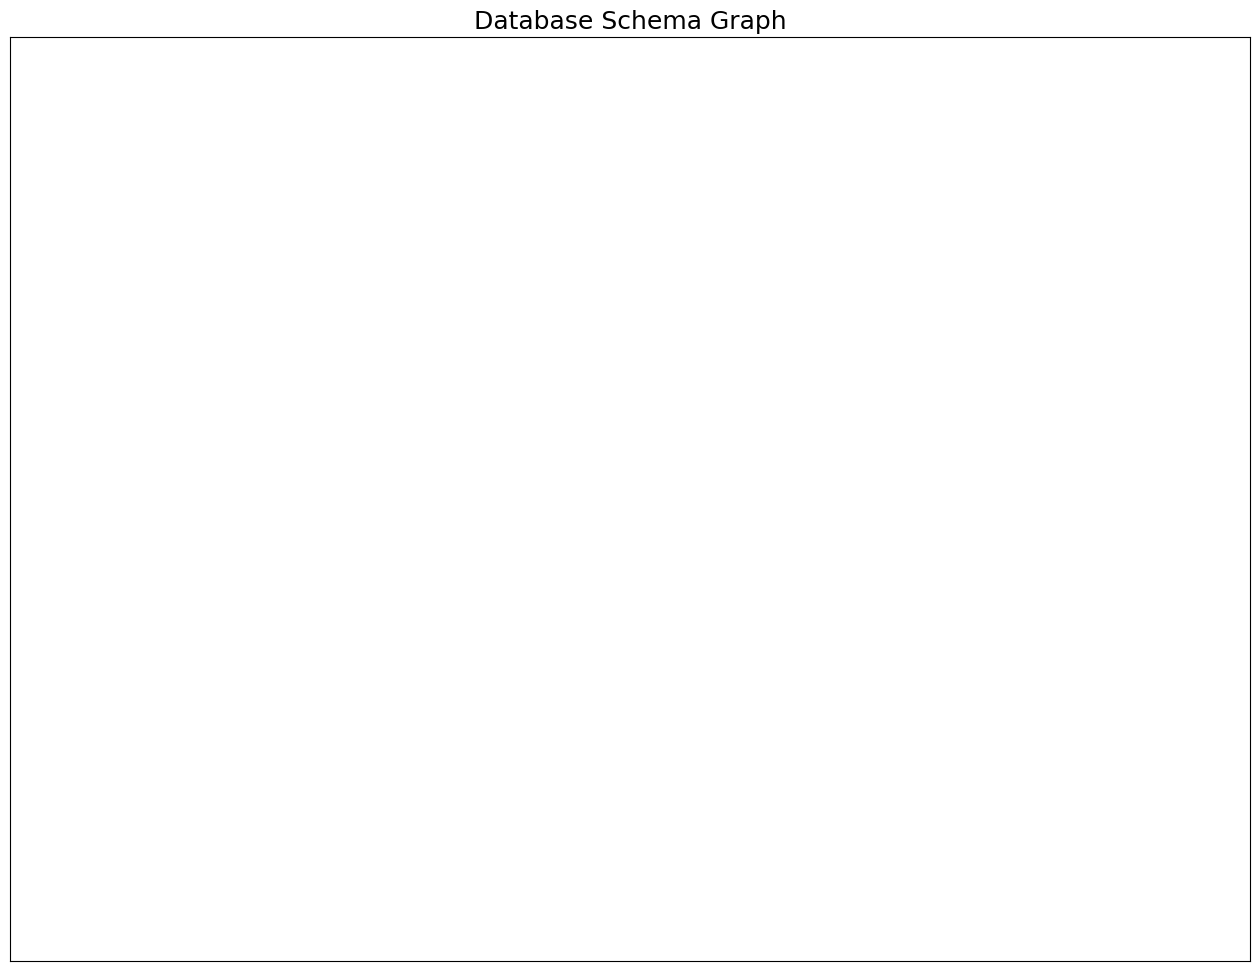

/tmp/ipykernel_2858/3428386683.py:94: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = self.llm([message])



LLM Analysis:
I don't see any schema information provided. Please share the actual schema details, and I'll be happy to help you identify any redundant columns or similar tables.


In [25]:
from sqlalchemy import MetaData
from sqlalchemy.engine import create_engine
import networkx as nx
from langchain_ollama import ChatOllama
from langchain.schema import HumanMessage
import matplotlib.pyplot as plt

class DatabaseGraphAnalyzer:
    def __init__(self, db_urls, llm_model="llama3.2"):
        """
        Initializes the DatabaseGraphAnalyzer with the provided database URLs.
        
        Parameters:
        - db_urls (dict): Dictionary where keys are database names and values are their connection URLs.
        - llm_model (str): LLM model name to use for semantic analysis.
        """
        self.db_urls = db_urls
        self.graph = nx.DiGraph()
        self.llm = ChatOllama(model=llm_model)
        
        # Store metadata for each database
        self.metadata = {}
        for db_name, url in db_urls.items():
            engine = create_engine(url)
            metadata = MetaData()
            metadata.reflect(bind=engine)
            self.metadata[db_name] = metadata
            self._add_metadata_to_graph(metadata, db_name)

    def _add_metadata_to_graph(self, metadata, db_name):
        """
        Adds database metadata to the graph, where each table and column are represented as nodes.
        Relationships such as foreign keys are represented as edges.
        
        Parameters:
        - metadata (MetaData): SQLAlchemy MetaData object containing the schema information.
        - db_name (str): Name of the database to associate with these tables and columns.
        """
        for table_name, table in metadata.tables.items():
            # Add a table node
            table_node = f"{db_name}.{table_name}"
            self.graph.add_node(table_node, type="table", db=db_name, label=f"Table: {table_name} ({db_name})")

            # Add column nodes and link to the table
            for column in table.columns:
                column_node_id = f"{db_name}.{table_name}.{column.name}"
                self.graph.add_node(column_node_id, type="column", db=db_name, label=f"Column: {column.name} ({table_name})", data_type=str(column.type))
                self.graph.add_edge(table_node, column_node_id, relationship="contains")

            # Link foreign keys between columns
            for fk in table.foreign_keys:
                parent_column = f"{db_name}.{fk.parent.table.name}.{fk.parent.name}"
                referenced_column = f"{db_name}.{fk.column.table.name}.{fk.column.name}"
                self.graph.add_edge(parent_column, referenced_column, relationship="foreign_key")

    def visualize_graph(self):
        """
        Visualizes the combined database metadata graph with nodes and edges representing tables and columns.
        """
        node_colors = ['skyblue' if data['type'] == 'table' else 'lightgreen' for _, data in self.graph.nodes(data=True)]
        pos = nx.spring_layout(self.graph, k=0.5, iterations=50)
        
        plt.figure(figsize=(16, 12))
        nx.draw_networkx_nodes(self.graph, pos, node_color=node_colors, node_size=1500, alpha=0.8)
        nx.draw_networkx_labels(self.graph, pos, labels=nx.get_node_attributes(self.graph, 'label'), font_size=8, font_weight='bold')
        nx.draw_networkx_edges(self.graph, pos, edgelist=self.graph.edges(data=True), arrowstyle='-|>', arrowsize=20, edge_color='black')
        plt.title("Database Schema Graph", fontsize=18)
        plt.show()

    def query_schema_with_prompt(self, custom_prompt):
        """
        Query the LLM using a custom prompt and the schema information extracted.
        
        Parameters:
        - custom_prompt (str): The custom prompt to send to the LLM for analysis.
        
        Returns:
        str: LLM response to the custom prompt.
        """
        # Extract table information
        table_info = {node: {"columns": []} for node, data in self.graph.nodes(data=True) if data['type'] == 'table'}
        for node, data in self.graph.nodes(data=True):
            if data['type'] == 'column':
                table_name = '.'.join(node.split('.')[:-1])  # Extract table name from column node
                if table_name in table_info:
                    table_info[table_name]['columns'].append(data['label'])
        
        # Format the schema information for the prompt
        table_details = "\n".join([f"Table {key} has columns: {', '.join(value['columns'])}" for key, value in table_info.items()])
        prompt_content = f"{custom_prompt}\n\nSchema Information:\n{table_details}"
        
        # Send the prompt to the LLM
        message = HumanMessage(content=prompt_content)
        response = self.llm([message])
        
        print(f"\nLLM Analysis:\n{response.content}")
        return response.content

# Main function to run the analyzer with sample databases
def main():
    # Example database URLs
    db_urls = {
        "example1": "sqlite:///example1.db",
        "example2": "sqlite:///example2.db"
    }

    # Initialize and analyze the databases
    analyzer = DatabaseGraphAnalyzer(db_urls)
    analyzer.visualize_graph()

    # Perform a custom LLM query on the schema
    custom_prompt = "Identify redundant columns or similar tables in this schema."
    analyzer.query_schema_with_prompt(custom_prompt)

# Run the main function if the script is executed
if __name__ == "__main__":
    main()
